In [2]:
import pickle
from datetime import timedelta

import pandas as pd
import numpy as np
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from config import SQLQuery

In [3]:
querySno = SQLQuery('snowflake')

In [16]:
fraud = querySno(
"""
with funded_accounts_tmp as (
select distinct a.BUSINESS_ID, a.APPLICATION_ID, DATEDIFF(day, ACCOUNT_CREATE_DATE, TRANSACTION_DATE) as DAYS_SINCE_CREATED from 
(
  select distinct APPLICATION_ID, BUSINESS_ID, ACCOUNT_CREATE_DATE from "PROD_DB"."DATA"."BUSINESSES"
  where ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
) a
inner join
(
  select distinct BUSINESS_ID, TRANSACTION_DATE from "PROD_DB"."DATA"."TRANSACTIONS" where type='credit' and status='active'
) b
on a.BUSINESS_ID=b.BUSINESS_ID
where a.APPLICATION_ID is not null and DAYS_SINCE_CREATED between  0 and 60
),

funded_accounts as (
select distinct BUSINESS_ID, APPLICATION_ID from funded_accounts_tmp
),

loss_tx as (
       select *
        from (
            select business_id
            , RANK() OVER (PARTITION BY business_id
                ORDER BY transaction_date DESC) returned_rank
            , amount as loss_tx_amount
            , created_date loss_tx_created_at
            , transaction_date loss_tx_transaction_date
            from prod_db.data.transactions
            where 1=1
                and medium in ('Descriptive Deposit', 'Closeout Withdrawal')
                and amount > 0
                and running_balance = 0
        )
        where returned_rank=1
),

fraud_closure_accounts as (
    select business_id, closure_reason, business_type, account_close_date, ACCOUNT_CREATE_DATE 
    ,ACCOUNT_STATUS, CLOSURE_IS_SUSPECT_FRAUD
        ,  case 
                when datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) > 60 then '60+' 
                when  datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) between 31 and 60 then '60'
                when  datediff(day, ACCOUNT_CREATE_DATE, coalesce(account_close_date, current_date())) between 0 and 30 then '30'
            end  as days_on_books
        , cast(date_trunc(month, account_close_date) as date) as account_close_month
    from prod_db.data.businesses 
    where 1=1
        and closure_reason ilike '%fraud%' 
        and account_close_date is not null 
        and ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
),

fraud_acounts_less_60 as (
select distinct f.business_id, 1 as fraud from 
    (select * from fraud_closure_accounts where days_on_books in ('30', '60')) f 
inner join loss_tx l on f.business_id = l.business_id
),

fraud_acounts_greater_60 as (
select distinct f.business_id, 1 as fraud from 
    (select * from fraud_closure_accounts where days_on_books='60+' ) f 
inner join loss_tx l on f.business_id = l.business_id
),

fraud_accounts_txns as (
select a.* from prod_db.data.transactions a
join fraud_acounts_less_60 b on a.business_id=b.business_id
),

distinct_app_id_tmp1 as (
select distinct 
a.business_id, a.APPLICATION_ID,
case 
    when b.fraud=1 then 1
    else 0
end as fraud 
from funded_accounts a
left join
fraud_acounts_less_60 b
on a.business_id=b.business_id
),

distinct_app_id as (
select a.* from distinct_app_id_tmp1 a
left join
fraud_acounts_greater_60 b
on a.business_id=b.business_id 
where b.business_id is null
)

select * from distinct_app_id

""")


In [17]:
# 109137 created in the period but closed even after Feb'22
fraud.shape

(109137, 3)

In [18]:
fraud['fraud'].value_counts()

0    108661
1       476
Name: fraud, dtype: int64

In [19]:
476*100/109137

0.4361490603553332

### Applications Features 

In [20]:
app_data = querySno(
"""
select
APPLICATION_ID,
IS_EMAIL_VALID,
EMAIL_IS_VERIFIED,
AZLO_REFERRAL,
APPLICATION_START_DATETIME,
APPLICATION_COMPLETE_DATETIME,
APPLICATION_RESUBMITTED_DATETIME,
NUMBER_INCOMPLETE_EVENTS,
AML_RISK_SCORE,
HIGH_RISK_INDUSTRY,
UTM_SOURCE,
UTM_MEDIUM,
APPLICATION_CHANNEL,
ESTIMATED_MONTHLY_REVENUE,
INCOMING_ACH_PAYMENTS,
CHECK_DEPOSIT_AMOUNT,
INCOMING_WIRE_TRANSFER,
OUTGOING_ACH_AND_CHECKS,
OUTGOING_WIRE_TRANSFERS,
NUMBER_OF_EMPLOYEES,
HAS_INTERNATIONAL_BUSINESS,
LEGAL_NAME_EXIST_IN_DOC,
HEAR_ABOUT_NOVO,
INDUSTRY_CATEGORY_ID,
INDUSTRY_CATEGORY_NAME,
DATE_OF_ESTABLISHMENT,
BUSINESS_TYPE
from prod_db.data.applications 
where ACCOUNT_OPENED_DATETIME between '2021-01-01' and '2022-02-28'
"""
)

In [21]:
app_data.shape

(143800, 27)

In [22]:
fraud_app_data = pd.merge(fraud, app_data, on='application_id')

In [23]:
len(pd.unique(fraud_app_data['application_id']))

108942

In [24]:
fraud_app_data.shape

(108942, 29)

In [25]:
fraud_app_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108942 entries, 0 to 108941
Data columns (total 29 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   business_id                       108942 non-null  object        
 1   application_id                    108942 non-null  object        
 2   fraud                             108942 non-null  int64         
 3   is_email_valid                    108942 non-null  object        
 4   email_is_verified                 108942 non-null  bool          
 5   azlo_referral                     108942 non-null  bool          
 6   application_start_datetime        108942 non-null  datetime64[ns]
 7   application_complete_datetime     108879 non-null  datetime64[ns]
 8   application_resubmitted_datetime  32605 non-null   datetime64[ns]
 9   number_incomplete_events          108942 non-null  int64         
 10  aml_risk_score                  

In [31]:
cat_columns = ['is_email_valid','email_is_verified','azlo_referral','number_incomplete_events',
               'application_channel','estimated_monthly_revenue',
               'incoming_ach_payments',
              'check_deposit_amount','incoming_wire_transfer','outgoing_ach_and_checks','outgoing_wire_transfers',
              'has_international_business','legal_name_exist_in_doc','hear_about_novo',
               'industry_category_name','business_type'
              ]
del_columns = ['application_resubmitted_datetime','utm_source','utm_medium','industry_category_id']

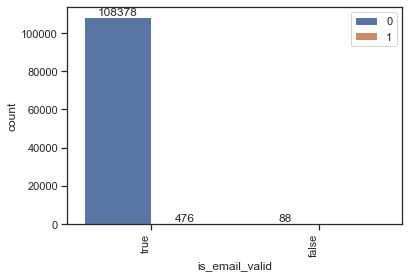

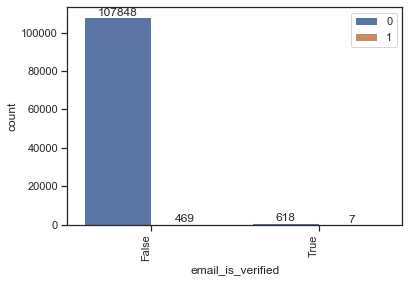

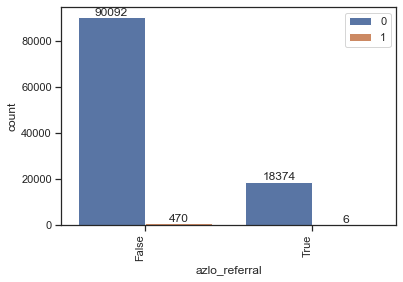

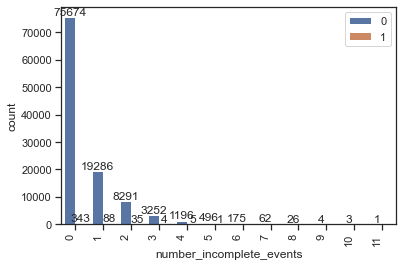

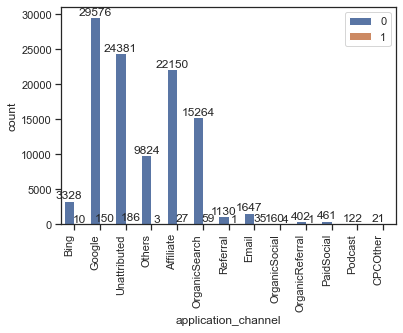

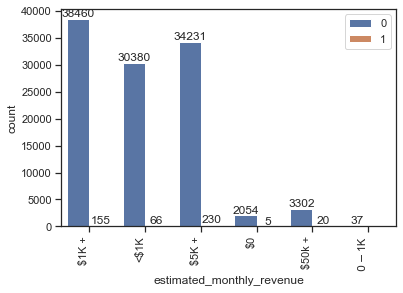

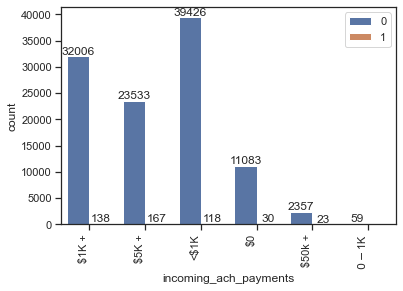

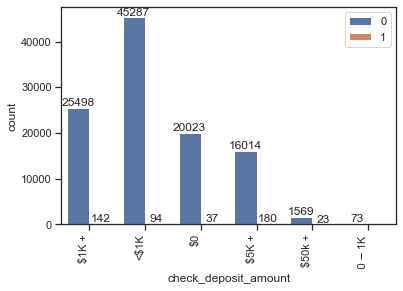

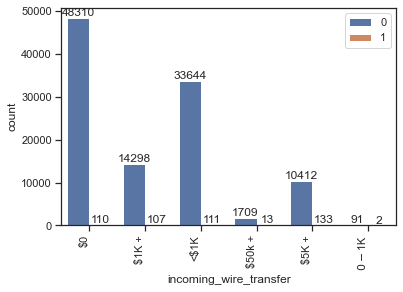

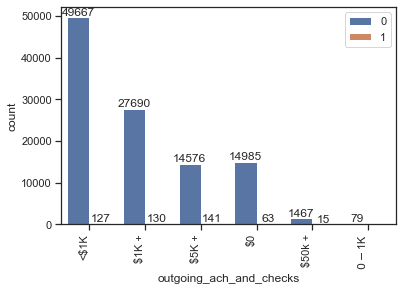

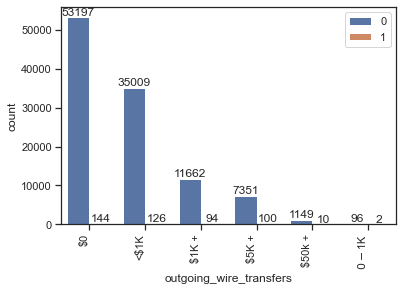

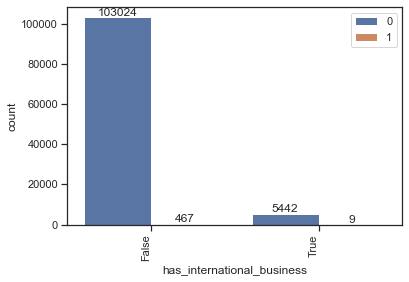

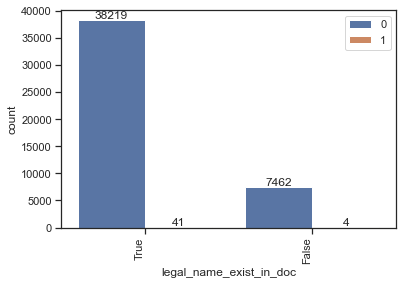

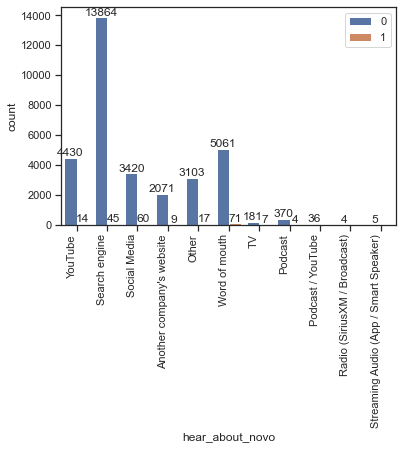

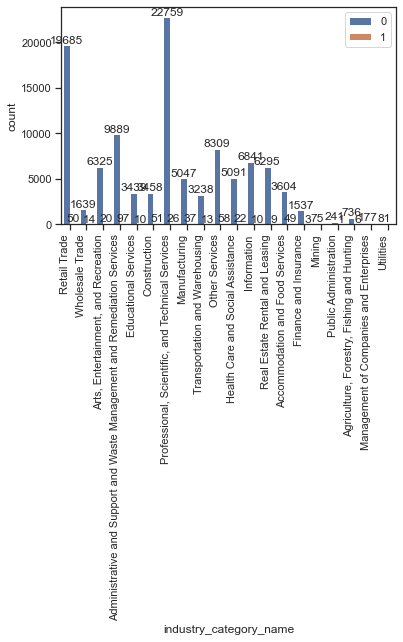

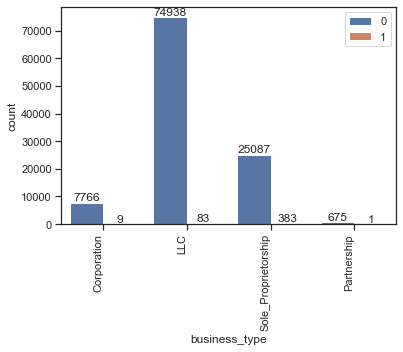

In [32]:
for i, col in enumerate(cat_columns):
    plt.figure()
    ax = sns.countplot(x=col, hue='fraud', data = fraud_app_data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
    for bars in ax.containers:
        ax.bar_label(bars, fmt='%.0f')
    plt.legend(loc='upper right')


In [33]:
# cols = ['azlo_referral','fraud']
# data = fraud_app_data[cols]
# data1 = data.groupby(cols).size()
# data1

In [34]:
fraud_app_data.corr()

,fraud,email_is_verified,azlo_referral,number_incomplete_events,aml_risk_score,has_international_business
fraud,1.000000,0.007867,-0.027614,-0.006562,0.080790,-0.009458
email_is_verified,0.007867,1.000000,0.013810,0.047385,-0.027598,0.002635
azlo_referral,-0.027614,0.013810,1.000000,-0.064178,-0.146217,0.033091
number_incomplete_events,-0.006562,0.047385,-0.064178,1.000000,-0.069329,0.018687
aml_risk_score,0.080790,-0.027598,-0.146217,-0.069329,1.000000,0.005526
has_international_business,-0.009458,0.002635,0.033091,0.018687,0.005526,1.000000


### Alloy Persons Features 

In [179]:
alloy_persons_data = querySno(
"""
with alloy_persons_data as (
select distinct
APPLICATION_ID,
PERSON_SCORE,
IDA_SCORE,
IOVATION_PROXY_IN_USE,
SENTILINK_ABUSE_SCORE,
SENTILINK_FIRST_PARTY_SYNTHETIC_SCORE,
SENTILINK_THIRD_PARTY_SYNTHETIC_SCORE,
SENTILINK_ID_THEFT_SCORE,
SOCURE_SIGMA,
SOCURE_EMAILRISK,
SOCURE_PHONERISK,
SOCURE_ADDRESSRISK,
rank() over(partition by APPLICATION_ID order by APPLICATION_VERSION_ID desc) as ranking
from prod_db.data.ALLOY_EVALUATIONS_PERSONS 
),


apps_data as (
select
APPLICATION_ID,
IS_EMAIL_VALID,
EMAIL_IS_VERIFIED,
AZLO_REFERRAL,
APPLICATION_START_DATETIME,
APPLICATION_COMPLETE_DATETIME,
APPLICATION_RESUBMITTED_DATETIME,
NUMBER_INCOMPLETE_EVENTS,
AML_RISK_SCORE,
HIGH_RISK_INDUSTRY,
UTM_SOURCE,
UTM_MEDIUM,
APPLICATION_CHANNEL,
ESTIMATED_MONTHLY_REVENUE,
INCOMING_ACH_PAYMENTS,
CHECK_DEPOSIT_AMOUNT,
INCOMING_WIRE_TRANSFER,
OUTGOING_ACH_AND_CHECKS,
OUTGOING_WIRE_TRANSFERS,
NUMBER_OF_EMPLOYEES,
HAS_INTERNATIONAL_BUSINESS,
LEGAL_NAME_EXIST_IN_DOC,
HEAR_ABOUT_NOVO,
INDUSTRY_CATEGORY_ID,
INDUSTRY_CATEGORY_NAME,
DATE_OF_ESTABLISHMENT,
BUSINESS_TYPE
from prod_db.data.applications 
where ACCOUNT_OPENED_DATETIME between '2021-01-01' and '2022-02-28'
)

select a.* from (
select * from alloy_persons_data where ranking=1) a
join
apps_data b
on a.APPLICATION_ID=b.APPLICATION_ID

"""

)

In [180]:
alloy_persons_data.shape

(143795, 13)

In [181]:
fraud_alloy_persons_data = pd.merge(fraud, alloy_persons_data, on='application_id')

In [182]:
fraud_alloy_persons_data.shape

(108937, 15)

In [188]:
len(pd.unique(fraud['application_id'])) - len(pd.unique(fraud_alloy_persons_data['application_id']))

201

In [173]:
108942

108942

In [ ]:
closed_accounts = querySno(
"""
with loss_tx as (
       select *
        from (
            select business_id
            , RANK() OVER (PARTITION BY business_id
                ORDER BY transaction_date DESC) returned_rank
            , amount as loss_tx_amount
            , created_date loss_tx_created_at
            , transaction_date loss_tx_transaction_date
            from prod_db.data.transactions
            where 1=1
                and medium in ('Descriptive Deposit', 'Closeout Withdrawal')
                and amount > 0
                and running_balance = 0
        )
        where returned_rank=1
),

fraud_closure_accounts as (
    select business_id, closure_reason, business_type, account_close_date, ACCOUNT_CREATE_DATE 
    ,ACCOUNT_STATUS, CLOSURE_IS_SUSPECT_FRAUD
    from prod_db.data.businesses 
    where 1=1
        and closure_reason ilike '%fraud%' 
        and account_close_date is not null 
        and account_close_date between '2021-01-01' and '2022-02-28'
),

fraud_acounts as (
select distinct f.business_id, 1 as fraud from fraud_closure_accounts f 
inner join loss_tx l on f.business_id = l.business_id
)

select count(*) as fraud from fraud_acounts where fraud=1
""")


In [ ]:
closed_accounts

In [ ]:
opened_accounts = querySno(
"""
with loss_tx as (
       select *
        from (
            select business_id
            , RANK() OVER (PARTITION BY business_id
                ORDER BY transaction_date DESC) returned_rank
            , amount as loss_tx_amount
            , created_date loss_tx_created_at
            , transaction_date loss_tx_transaction_date
            from prod_db.data.transactions
            where 1=1
                and medium in ('Descriptive Deposit', 'Closeout Withdrawal')
                and amount > 0
                and running_balance = 0
        )
        where returned_rank=1
),

fraud_closure_accounts as (
    select business_id, closure_reason, business_type, account_close_date, ACCOUNT_CREATE_DATE 
    ,ACCOUNT_STATUS, CLOSURE_IS_SUSPECT_FRAUD
    from prod_db.data.businesses 
    where 1=1
        and closure_reason ilike '%fraud%' 
        and account_close_date is not null 
        and account_close_date between '2021-01-01' and '2022-02-28'
        and ACCOUNT_CREATE_DATE between '2021-01-01' and '2022-02-28'
),

fraud_acounts as (
select distinct f.business_id, 1 as fraud from fraud_closure_accounts f 
inner join loss_tx l on f.business_id = l.business_id
)

select count(*) as fraud from fraud_acounts where fraud=1
""")


In [ ]:
opened_accounts